[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/main/notebooks/herculens__Spiral_galaxy_Bayesian_sparsity_Laplace.ipynb)

# Modeling a spiral galaxy with Laplace prior in wavelet space

In this notebook we are interested in using the Laplace probability distribution as a sparsifying prior to regularize parameters of a pixelated light model. We apply it to the hypothetical case of a modeling the surface brightness distribution of a spiral galaxy, observed after convolution by the instrument PSF and contamination of noise.

__author__: @aymgal

__last updated__: 04/04/23

In [14]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [30]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro import optim
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.RegulModel.regul_model import RegularizationModel
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Inference.loss import Loss
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font size
FS = 18

## 1. Simulate the observation

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [31]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [32]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.2}
psf = PSF(**kwargs_psf)

### Noise

In [46]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 1e-2

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Load the galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

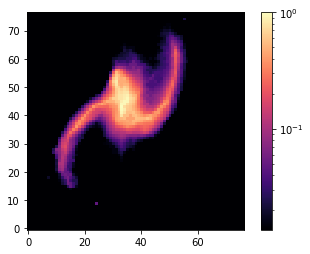

In [47]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
#merger = merger[80:, :-80]
merger = rescale(merger, 0.1, anti_aliasing=True)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(merger)

# we increase the contrast
merger[merger < 1e-2] = 1e-2

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm())
plt.colorbar()
plt.show()

In [48]:
kwargs_merger = {
    'pixel_scale_factor': 1,  # in arcsec
}
pprint(kwargs_merger)
light_model_input = LightModel(['PIXELATED'], pixel_interpol='bicubic',
                                kwargs_pixelated=kwargs_merger)
amp_src = 1. # 3e-1
kwargs_galaxy_input = [{'pixels': amp_src * merger}]

{'pixel_scale_factor': 1}


### Generate the lens image

In [52]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                            lens_light_model_class=light_model_input,
                            kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens_light=kwargs_galaxy_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=29)

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-2, flux_vmax=1e0, res_vmax=6)
plotter.set_data(data)

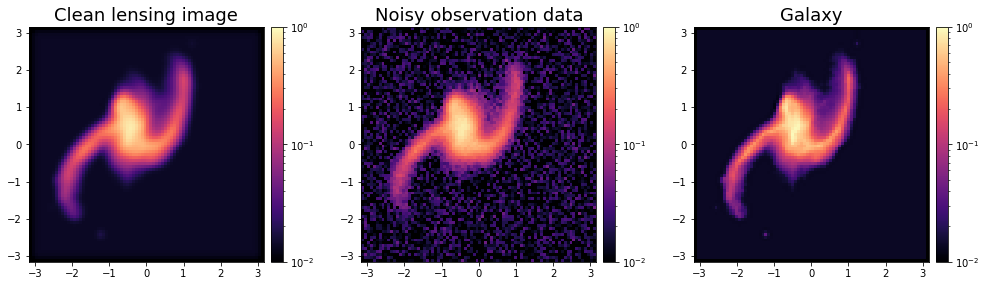

In [53]:
galaxy_input = lens_image_simu.lens_surface_brightness(kwargs_galaxy_input, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(galaxy_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Galaxy", fontsize=FS)
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## 2. Model the mock with a pixelated light model

### Create a model for fitting

In [54]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated = {
    'pixel_scale_factor': 1.,  # = data pixel size / source pixel size
}
light_model = LightModel(['PIXELATED'], kwargs_pixelated=kwargs_pixelated)

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_light_model_class=light_model,
                       kwargs_numerics=kwargs_numerics_fit)

galaxy_size = lens_image.LensLightModel.pixel_grid.num_pixel
galaxy_shape = lens_image.LensLightModel.pixel_grid.num_pixel_axes
print(galaxy_shape, galaxy_size)

(80, 80) 6400


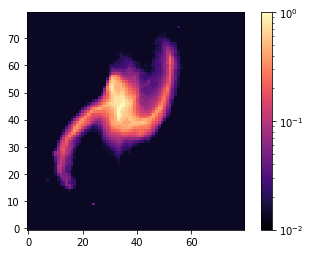

In [57]:
# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.LensLightModel.pixel_grid.pixel_coordinates
galaxy_input_fitgrid = lens_image_simu.LensLightModel.surface_brightness(x_grid_src, y_grid_src, kwargs_galaxy_input)
galaxy_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_lens_light(galaxy_input_fitgrid)

plt.imshow(galaxy_input_fitgrid, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

### Initialize the regularization model

In [58]:
# initialize the regularization model (can take a bit of time)
regul_model = RegularizationModel([('lens_light', 0, 'SPARSITY_STARLET_2')])
regul_model.initialize(lens_image, None, noise_var=lens_image.Noise.C_D, num_samples=5000)

(7, 80, 80)
1.1160325 14.882149


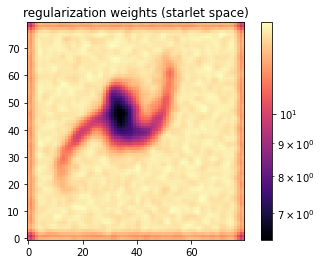

In [67]:
regul_weights = regul_model.get_weights()[0]
starlet = regul_model.method_list[0].transform

print(regul_weights.shape)
print(regul_weights.min(), regul_weights.max())

plt.figure()
plt.title("regularization weights (starlet space)")
plt.imshow(regul_weights[1], origin='lower', norm=LogNorm(), cmap='magma')
plt.colorbar()
plt.show()

In [70]:
nscales = regul_weights.shape[0] - 1  # -1 as shape[0] counts the coarse scale
nxsrc, nysrc = regul_weights.shape[1], regul_weights.shape[2]

class ProbModel(NumpyroModel):
    
    def model(self):
        
        # Define the prior distribution for the wavelet scales
        lambdas = jnp.array([5.] + [3.]*(nscales-1))[:, None, None]  # regularization strength
        mu_scales = jnp.zeros((nscales, nxsrc, nysrc))  # mean of the Laplace distribution
        b_scales = 1. / (lambdas * regul_weights[:-1])  # scale of the Laplace distribution
        dist_scales = dist.Laplace(mu_scales, b_scales)
        galaxy_scales = numpyro.sample('galaxy_scales', dist.Independent(dist_scales, 3))
        
        # Some distribution (not sparsifying!) for the coarse scale
        dist_coarse = dist.Uniform(jnp.zeros(galaxy_shape), jnp.ones(galaxy_shape))
        galaxy_coarse = numpyro.param('galaxy_coarse', init_value=1e-2*jnp.ones(galaxy_shape), 
                                      constraint=constraints.greater_than(0.), 
                                      event_dim=galaxy_shape)
        
        pixels = self.coeffs2galaxy(galaxy_scales, galaxy_coarse)
        prior_light = [{'pixels': pixels}]
        
        # generates the model image
        model_image = lens_image.model(kwargs_lens_light=prior_light)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)
    
    def coeffs2galaxy(self, scales, coarse):
        all_coeffs = jnp.concatenate((scales, coarse[jnp.newaxis, :, :]), axis=-3)
        #all_coeffs = jnp.concatenate((scales, coarse), axis=-3)
        pixels = starlet.reconstruct(all_coeffs)
        return pixels
   
    def params2kwargs(self, params):
        # functions that takes the flattenned dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        pixels = self.coeffs2galaxy(params['galaxy_scales'], params['galaxy_coarse'])
        kw = {'kwargs_lens_light': [{'pixels': pixels}]}
        return kw
    
    #def kwargs2params(self, kwargs):
    #    from jax.tree_util import tree_flatten
    #    return tree_flatten(kwargs)

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

Number of parameters: 44800


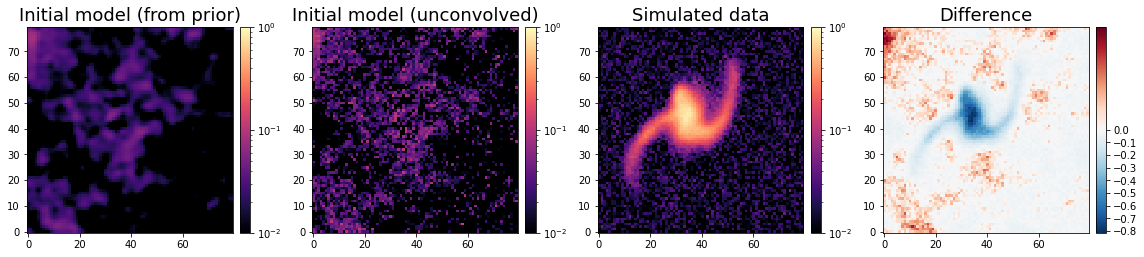

In [69]:
init_params = prob_model.get_sample(seed=0)
kwargs_init = prob_model.params2kwargs(init_params)
init_params_unconst = prob_model.unconstrain(init_params)
#pprint(kwargs_init)

# visualize initial guess
initial_model = lens_image.model(**kwargs_init)
initial_source = lens_image.LensLightModel.surface_brightness(x_grid_src, y_grid_src, kwargs_init['kwargs_lens_light']) * lens_image.Grid.pixel_area


fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial model (from prior)", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial model (unconvolved)", fontsize=FS)
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Loss function

In [62]:
loss = Loss(prob_model)

print("Loss at initial values:", loss(init_params_unconst))

Loss at initial values: 33493.09


### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [63]:
optimizer = OptaxOptimizer(loss, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 4000
init_learning_rate = 1e-4

best_fit_unconst, logL, extra_fields, runtime \
    = optimizer.run(init_params_unconst, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit_unconst))

optax.adabelief: 100%|██████████| 4000/4000 [01:41<00:00, 39.41it/s]


Runtime: 101.51554703712463
Loss at best-fit: -97844.07


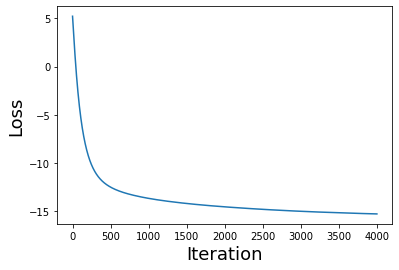

In [64]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

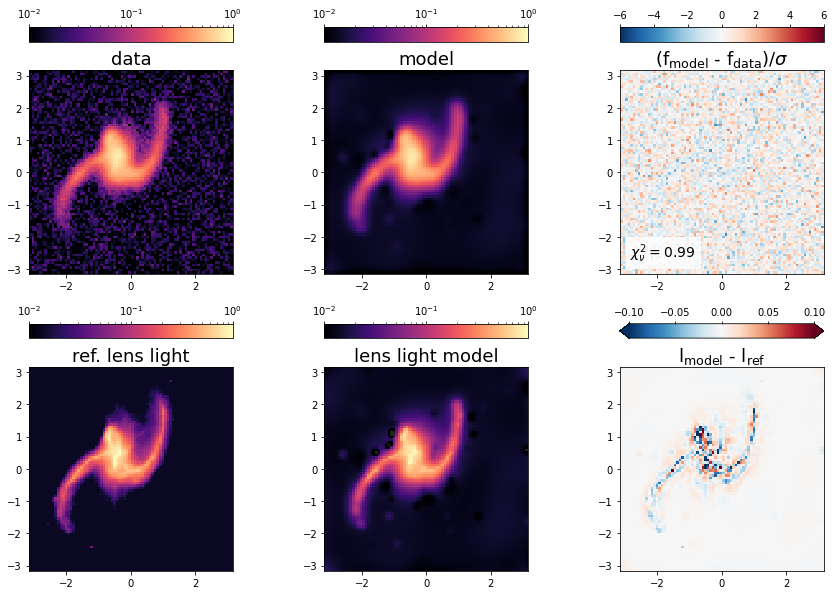

In [65]:
kwargs_bestfit = prob_model.params2kwargs(prob_model.constrain(best_fit_unconst))

fig = plotter.model_summary(lens_image, kwargs_bestfit, show_source=False, show_lens_light=True)
plt.show()

In [66]:
model_pixels = kwargs_bestfit['kwargs_lens_light'][0]['pixels'][20:25, 20:25]

print(model_pixels.min(), model_pixels.max())

0.013802544 0.019746603


## Model the posterior using variational inference

In the following we model the joint posterior distribution of the model via Stochastic Variational Inference, assuming a normal distribution with diagonal covariance (mean-field approximation).

In [ ]:
guide = AutoNormal(prob_model.model)

print(guide)

In [ ]:
num_iters = 6000

learning_rate = 3e-3
optimizer_vi = optim.Adam(learning_rate)

#import optax
#learning_rate = 3e-3
#optimizer_vi = optim.optax_to_numpyro(optax.adabelief(learning_rate))

svi = SVI(prob_model.model, guide, optimizer_vi, Trace_ELBO(num_particles=30))
print("Start training guide...")
svi_result = svi.run(jax.random.PRNGKey(1), num_iters)
print("Finish training guide. Extract samples...")

In [ ]:
# check convergence

plt.plot(svi_result.losses)
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss")
plt.show()

In [ ]:
num_samples = 5000
posterior_samples = guide.sample_posterior(
    jax.random.PRNGKey(2), svi_result.params, 
    sample_shape=(num_samples,)
)

guide_median = guide.median(svi_result.params)

#prior_samples = prob_model.sample_prior(num_samples, seed=18)

In [ ]:
posterior_samples.get('galaxy_coarse', None)

In [ ]:
# maximum-a-posterior estimate
model_map = kwargs_bestfit['kwargs_lens_light'][0]['pixels']

if 'galaxy_coarse' not in posterior_samples:
    # use the best-fit parameters from the SVI run as the coarse scale
    guide_median['galaxy_coarse'] = svi_result.params['galaxy_coarse']
    posterior_samples['galaxy_coarse'] = jnp.repeat(svi_result.params['galaxy_coarse'][None, :, :], num_samples, axis=0)

In [ ]:
posterior_samples['galaxy_coarse'].shape

In [ ]:
# median
model_median = prob_model.params2kwargs(guide_median)['kwargs_lens_light'][0]['pixels']

# mean and standard deviation
posterior_images = jax.vmap(prob_model.params2kwargs)(posterior_samples)['kwargs_lens_light'][0]['pixels']
model_mean = np.mean(posterior_images, axis=0)
model_std = np.std(posterior_images, axis=0)

In [ ]:
norm = LogNorm(1e-3, 1e0)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
ax = axes[0]
ax.set_title("groundtruth")
im = ax.imshow(galaxy_input_fitgrid, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[1]
ax.set_title("MAP solution")
im = ax.imshow(model_map, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[2]
ax.set_title("posterior median")
im = ax.imshow(model_median, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[3]
#ax.set_title("posterior mean")
#im = ax.imshow(model_mean, origin='lower', cmap=plotter.cmap_flux, norm=norm)
#plot_util.nice_colorbar(im)
#ax.set_xticklabels([]);ax.set_yticklabels([])
ax.set_title("SNR")
im = ax.imshow(np.abs(model_mean) / model_std, origin='lower', cmap='viridis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[4]
ax.set_title("posterior std dev")
im = ax.imshow(model_std, origin='lower', cmap='cividis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.tight_layout()
plt.show()